In [1]:
from DTNS import DiscreteTimeNN, DiscreteFailureTimeNLL, DiscreteFailureTimeCEL, create_batches, CI
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import torch

In [2]:
def load_support_dataset(random_state=0): # random_state=0 ensures reproducibility

    FILL_VALUES = {
        'alb': 3.5,
        'pafi': 333.3,
        'bili': 1.01,
        'crea': 1.01,
        'bun': 6.51,
        'wblc': 9.,
        'urine': 2502.
    }

    COLUMNS_TO_DROP = [
        'aps', 'sps', 'surv2m', 'surv6m', 'prg2m',
        'prg6m', 'dnr', 'dnrday', 'sfdm2', 'hospdead'
    ]

    df = (
        pd.read_csv("C:/Users/Yang Qing/OneDrive/Desktop/DTNS/data/support2.csv")
        .drop(COLUMNS_TO_DROP,axis=1)
        .fillna(value=FILL_VALUES)
        .sample(frac=1, random_state=random_state)
    )

    # one-hot encode categorical variables
    df = pd.get_dummies(df, dummy_na=True)

    # fill missing values to the median
    df = df.fillna(df.median())

    # standardize numeric columns
    numeric_cols = df.dtypes == 'float64'
    df.loc[:, numeric_cols] = df.loc[:, numeric_cols].transform(
        lambda x: (x - x.mean()) / x.std())
    
    features = (
        df
        .drop(['death', 'd.time'], axis=1)
        .values
        .astype(float)
    )
    
    event_indicator = df['death'].values.astype(float)
    event_time = df['d.time'].values.astype(float)

    return features, event_indicator, event_time

In [3]:
X, s, t = load_support_dataset()

In [4]:
test_idx = len(X) * 4 // 5

train_X, train_s, train_t = (arr[:test_idx] for arr in (X, s, t))
test_X, test_s, test_t = (arr[test_idx:] for arr in (X, s, t))

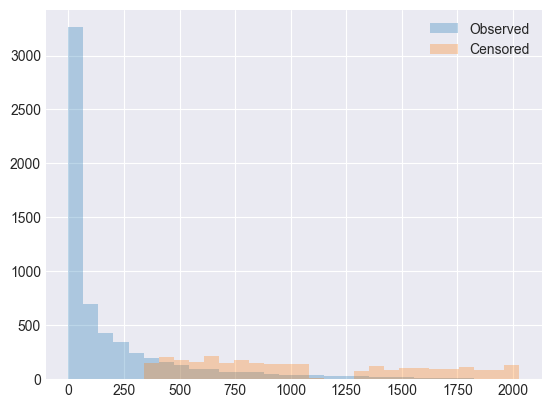

In [5]:
BIN_BOUNDARIES = np.arange(31) * (t.max() / 30)
plt.hist(t[s == 1], alpha=.3, bins=BIN_BOUNDARIES, label='Observed')
plt.hist(t[s == 0], alpha=.3, bins=BIN_BOUNDARIES, label='Censored')
plt.legend()
plt.show()

In [6]:
# We construct a model with a 100 hidden layer and 10 bins
model = DiscreteTimeNN((100, ), 30)
loss_fn = DiscreteFailureTimeNLL(BIN_BOUNDARIES)
optimizer = torch.optim.Adam(model.parameters())


c:\Users\Yang Qing\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


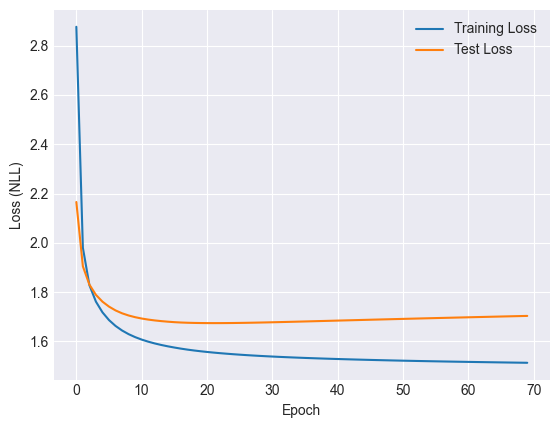

In [7]:
NUM_EPOCHS = 70

train_loss = []
test_loss = []

for epoch_idx in range(NUM_EPOCHS):
    
    epoch_train_loss = []
    epoch_test_loss = []

    for batch_X, batch_s, batch_t in create_batches(train_X, train_s, train_t, batch_size=100):

        optimizer.zero_grad()

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        epoch_train_loss.append(loss.item())
        
    for batch_X, batch_s, batch_t in create_batches(test_X, test_s, test_t, batch_size=100):
        # compared to the training process, we did not do back propagation and gradient calculation at this step
        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t)
        
        # Gather data and report
        epoch_test_loss.append(loss.item())
        
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
            
    print('Completed epoch %i; train loss = %.3f; test loss = %.3f' % (
        epoch_idx, train_loss[-1], test_loss[-1]), end='\r')
          
plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (NLL)')
plt.legend()
plt.show()

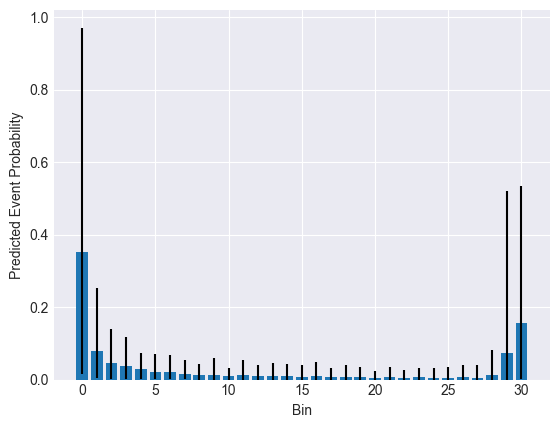

In [8]:
test_predictions = (
    model(torch.tensor(test_X, dtype=torch.float))
    .detach()
    .numpy()
)
# detach() creates a new tensor that does not require gradients, which can save memory and computational resources during inference.
# numpy converts tensors to numpy array directly
pred_mean = np.mean(test_predictions, axis=0)
pred_lower = np.percentile(test_predictions, 2.5, axis=0)
pred_upper = np.percentile(test_predictions, 97.5, axis=0)

plt.bar(
    np.arange(31),
    pred_mean,
    yerr=np.stack([
        pred_mean - pred_lower,
        pred_upper - pred_mean
    ]) # this calculates the error margin( the black vertical line)
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.show()

In [12]:
CI (test_s, test_t, test_predictions, 15)

ValueError: operands could not be broadcast together with shapes (1179,1821) (1179,1821,30) 

## Questions

what does cumulative_predicted_risk represents(in terms of the tensor)